# Project code

gg

In [271]:
import os
from pathlib import Path
import time

import cv2
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorly as tl
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.datasets import EMNIST
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision.transforms import v2

import utils

## Data loading utilities

In [272]:
# this dataset is already random rotated
handiso_ds_train = utils.CharDataset("data/handwritten-isolated-english/train")
handiso_ds_test = utils.CharDataset("data/handwritten-isolated-english/test")
handiso_test_data, handiso_test_labels = utils.ds_to_vectors(handiso_ds_test)

notmnist_ds = utils.CharDataset("data/notMNIST_small", transform=utils.T_randrot)
notmnist_ds_train, notmnist_ds_test = random_split(notmnist_ds, [0.8, 0.2])
notmnist_test_data, notmnist_test_labels = utils.ds_to_vectors(notmnist_ds_test)

stdocr_ds_train_orig = (
    utils.CharDataset("data/standard_ocr_dataset/data/training_data", transform=utils.T_randrot) +
    utils.CharDataset("data/standard_ocr_dataset/data2/training_data", transform=utils.T_randrot)
)
stdocr_ds_test = (
    utils.CharDataset("data/standard_ocr_dataset/data/testing_data", transform=utils.T_randrot) + 
    utils.CharDataset("data/standard_ocr_dataset/data2/testing_data", transform=utils.T_randrot)
)
stdocr_test_data, stdocr_test_labels = utils.ds_to_vectors(stdocr_ds_test)

mnist_ds_train_letters = EMNIST(Path(os.getcwd(), "data"), "letters", download=True, train=True, transform=utils.T_randrot, target_transform=utils.emnistletter_idx_to_class)
mnist_ds_train_digits = EMNIST(Path(os.getcwd(), "data"), "digits", download=True, train=True, transform=utils.T_randrot, target_transform=utils.emnistdigit_idx_to_class)
mnist_ds_train_orig = mnist_ds_train_letters + mnist_ds_train_digits
mnist_ds_test_letters = EMNIST(Path(os.getcwd(), "data"), "letters", download=True, train=False, transform=utils.T_randrot, target_transform=utils.emnistletter_idx_to_class)
mnist_ds_test_digits = EMNIST(Path(os.getcwd(), "data"), "digits", download=True, train=False, transform=utils.T_randrot, target_transform=utils.emnistdigit_idx_to_class)
mnist_ds_test_orig = mnist_ds_test_letters + mnist_ds_test_digits

Image data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png is not a valid image, skipping
Image data/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png is not a valid image, skipping
Image data/standard_ocr_dataset/data2/testing_data/G/44404.png is not a valid image, skipping


In [273]:
print(f"handwritten-isolated-english sizes: [train:{len(handiso_ds_train)}, test:{len(handiso_ds_test)}]")
print(f"not MNIST sizes: [train:{len(notmnist_ds_train)}, test:{len(notmnist_ds_test)}]")
print(f"standard OCR ds sizes: [train:{len(stdocr_ds_train_orig)}, test:{len(stdocr_ds_test)}]")
print(f"EMNIST sizes: [train:{len(mnist_ds_train_orig)}, test:{len(mnist_ds_test_orig)}]")

handwritten-isolated-english sizes: [train:13168, test:1792]
not MNIST sizes: [train:14980, test:3744]
standard OCR ds sizes: [train:41256, test:4249]
EMNIST sizes: [train:364800, test:60800]


In [274]:
# EMNIST dataset is way too large for our purposes, we only take a subset of it
stdocr_ds_train, _ = random_split(stdocr_ds_train_orig, [0.5, 0.5])
mnist_ds_train, _ = random_split(mnist_ds_train_orig, [0.05, 0.95])
mnist_ds_test, _ = random_split(mnist_ds_test_orig, [0.05, 0.95])
mnist_test_data, mnist_test_labels = utils.ds_to_vectors(mnist_ds_test)

In [275]:
print(f"handwritten-isolated-english sizes: [train:{len(handiso_ds_train)}, test:{len(handiso_ds_test)}]")
print(f"not MNIST sizes: [train:{len(notmnist_ds_train)}, test:{len(notmnist_ds_test)}]")
print(f"standard OCR ds sizes: [train:{len(stdocr_ds_train)}, test:{len(stdocr_ds_test)}]")
print(f"EMNIST sizes: [train:{len(mnist_ds_train)}, test:{len(mnist_ds_test)}]")

handwritten-isolated-english sizes: [train:13168, test:1792]
not MNIST sizes: [train:14980, test:3744]
standard OCR ds sizes: [train:20628, test:4249]
EMNIST sizes: [train:18240, test:3040]


In [276]:
consolidated_ds_train = handiso_ds_train + notmnist_ds_train + stdocr_ds_train + mnist_ds_train
consolidated_ds_test = handiso_ds_test + notmnist_ds_test + stdocr_ds_test + mnist_ds_test

In [277]:
cons_train_data, cons_train_labels = utils.ds_to_vectors(consolidated_ds_train)
cons_test_data, cons_test_labels = utils.ds_to_vectors(consolidated_ds_test)

## Utility functions for model setup and testing

In [278]:
def run_all_tests_model(model, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = utils.tic()
    handwrscore = model.score(data_transform(handiso_test_data), handiso_test_labels)
    notmnistscore = model.score(data_transform(notmnist_test_data), notmnist_test_labels)
    stdocrscore = model.score(data_transform(stdocr_test_data), stdocr_test_labels)
    mnistscore = model.score(data_transform(mnist_test_data), mnist_test_labels)
    utils.toc(ts, "Model testing")
    tot_test = len(handiso_test_labels) + len(notmnist_test_labels) + len(stdocr_test_labels) + len(mnist_test_labels)
    weighted_score = (handwrscore * len(handiso_test_labels) + notmnistscore * len(notmnist_test_labels) + stdocrscore * len(stdocr_test_labels) + mnistscore * len(mnist_test_labels)) / tot_test
    print(f"handwritten-isolated score: {handwrscore}\n"
          f"notMNIST score: {notmnistscore}\n"
          f"standard OCR score: {stdocrscore}\n"
          f"EMNIST score: {mnistscore}\n"
          f"Aggregate score: {weighted_score}")
    return handwrscore, notmnistscore, stdocrscore, mnistscore, weighted_score

def test_trf_models(create_model_func, trf_funcs, mincomps, maxcomps):
    """
    create_model_func: (X, y, data_transform=func) -> scipy classification model
    """
    assert len(trf_funcs) == (maxcomps + 1) - mincomps
    handwrscores, notmnistscores, stdocrscores, mnistscores, aggscores = [], [], [], [], []
    traintimes, predicttimes = [], []
    for ncomp in range(mincomps, maxcomps + 1):
        print(f"n_components: {ncomp}")
        trf = trf_funcs[ncomp - mincomps]
        ts = utils.tic()
        consol_model = create_model_func(cons_train_data, cons_train_labels, data_transform=trf)
        traintimes.append(utils.toc(ts, printtime=False))
        ts = utils.tic()
        handwrscore, notmnistscore, stdocrscore, mnistscore, aggscore = run_all_tests_model(consol_model, data_transform=trf)
        predicttimes.append(utils.toc(ts, printtime=False))
        handwrscores.append(handwrscore)
        notmnistscores.append(notmnistscore)
        stdocrscores.append(stdocrscore)
        mnistscores.append(mnistscore)
        aggscores.append(aggscore)
        print("------")
    return {
        "handwrscores": handwrscores,
        "notmnistscores": notmnistscores,
        "stdocrscores": stdocrscores,
        "mnistscores": mnistscores,
        "aggscores": aggscores,
        "traintimes": traintimes,
        "predicttimes": predicttimes
    }

def plot_scores(results, ncomplist, title="Classification results for dimensionality reduction"):
    fig, ax = plt.subplots()
    ax.plot(ncomplist, results["handwrscores"], "-", label="handwritten-isolated")
    ax.plot(ncomplist, results["notmnistscores"], "-", label="notMNIST")
    ax.plot(ncomplist, results["stdocrscores"], "-", label="standard OCR")
    ax.plot(ncomplist, results["mnistscores"], "-", label="EMNIST")
    ax.plot(ncomplist, results["aggscores"], "--", label="aggregated")
    ax.set_xlabel("number of components")
    ax.set_ylabel("test accuracy")
    ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [279]:
def create_logreg(X, y, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = utils.tic()
    logreg = LogisticRegression()
    logreg.fit(data_transform(X), y)
    utils.toc(ts, "Logistic Regression training")
    return logreg

def create_knn(X, y, k=5, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = utils.tic()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_transform(X), y)
    utils.toc(ts, "KNN training")
    return knn

## Raw model tests

In [280]:
# logistic regression linear classifier
consol_logreg = create_logreg(cons_train_data, cons_train_labels)
run_all_tests_model(consol_logreg)

Logistic Regression training took: 34.706820249557495 sec.

Model testing took: 0.07656002044677734 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.5771901709401709
standard OCR score: 0.45116497999529304
EMNIST score: 0.43486842105263157
Aggregate score: 0.4271345029239766


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.04352678571428571,
 0.5771901709401709,
 0.45116497999529304,
 0.43486842105263157,
 0.4271345029239766)

In [281]:
# KNN classifier
consol_knn = create_knn(cons_train_data, cons_train_labels, k=5)
run_all_tests_model(consol_knn)

KNN training took: 0.006300926208496094 sec.



Model testing took: 13.052629947662354 sec.

handwritten-isolated score: 0.6037946428571429
notMNIST score: 0.7919337606837606
standard OCR score: 0.8945634266886326
EMNIST score: 0.7161184210526316
Aggregate score: 0.7816764132553606


(0.6037946428571429,
 0.7919337606837606,
 0.8945634266886326,
 0.7161184210526316,
 0.7816764132553606)

## Tests with PCA

In [283]:
def create_pca(X, n_components):
    ts = utils.tic()
    pca = PCA(n_components=n_components)
    pca.fit(X)
    utils.toc(ts, "Creating PCA components")
    return pca

# could probably just initialize PCA with max components first, then just subset the
# eigenvectors, but I'm too lazy to do that
allpcas = [create_pca(cons_train_data, i) for i in range(2, 60)]
pcatrf_funcs = [pca.transform for pca in allpcas]

Creating PCA components took: 1.1809241771697998 sec.

Creating PCA components took: 1.0720000267028809 sec.

Creating PCA components took: 1.2223529815673828 sec.

Creating PCA components took: 1.1452910900115967 sec.

Creating PCA components took: 1.0326950550079346 sec.

Creating PCA components took: 1.563870906829834 sec.

Creating PCA components took: 0.9623832702636719 sec.

Creating PCA components took: 1.284830093383789 sec.

Creating PCA components took: 2.1858859062194824 sec.

Creating PCA components took: 2.449094295501709 sec.

Creating PCA components took: 2.4147298336029053 sec.

Creating PCA components took: 2.468219757080078 sec.

Creating PCA components took: 2.357678174972534 sec.

Creating PCA components took: 3.525146722793579 sec.

Creating PCA components took: 3.4355456829071045 sec.

Creating PCA components took: 2.3651790618896484 sec.

Creating PCA components took: 2.541043996810913 sec.

Creating PCA components took: 2.6871769428253174 sec.

Creating PCA comp

In [284]:
pcatrf_funcs = [pca.transform for pca in allpcas]

### Logistic regression linear classifier

In [285]:
logreg_pca_results = test_trf_models(create_logreg, pcatrf_funcs, 2, 59)

n_components: 2


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.660299062728882 sec.

Model testing took: 0.0407559871673584 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.1875
standard OCR score: 0.014827018121911038
EMNIST score: 0.11973684210526316
Aggregate score: 0.09325536062378167
------
n_components: 3


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.671694278717041 sec.

Model testing took: 0.03338289260864258 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.18669871794871795
standard OCR score: 0.02494704636385032
EMNIST score: 0.16940789473684212
Aggregate score: 0.10955165692007797
------
n_components: 4


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.525557041168213 sec.

Model testing took: 0.03853917121887207 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.23050213675213677
standard OCR score: 0.02588844433984467
EMNIST score: 0.1713815789473684
Aggregate score: 0.1228849902534113
------
n_components: 5


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.8569958209991455 sec.

Model testing took: 0.04689502716064453 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.2863247863247863
standard OCR score: 0.016945163567898328
EMNIST score: 0.18980263157894736
Aggregate score: 0.14019493177387915
------
n_components: 6


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.9885787963867188 sec.

Model testing took: 0.038645029067993164 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.3993055555555556
standard OCR score: 0.021887502941868676
EMNIST score: 0.24868421052631579
Aggregate score: 0.18869395711500975
------
n_components: 7


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.511359930038452 sec.

Model testing took: 0.04911208152770996 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.4099893162393162
standard OCR score: 0.040715462461755704
EMNIST score: 0.2802631578947368
Aggregate score: 0.2056140350877193
------
n_components: 8


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.7441186904907227 sec.

Model testing took: 0.057836055755615234 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.48370726495726496
standard OCR score: 0.057660626029654036
EMNIST score: 0.30164473684210524
Aggregate score: 0.23742690058479532
------
n_components: 9


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.681859016418457 sec.

Model testing took: 0.055022239685058594 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.5235042735042735
standard OCR score: 0.07342904212755942
EMNIST score: 0.3282894736842105
Aggregate score: 0.26035087719298244
------
n_components: 10


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.384088039398193 sec.

Model testing took: 0.05741000175476074 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.5301816239316239
standard OCR score: 0.0738997411155566
EMNIST score: 0.3404605263157895
Aggregate score: 0.2658869395711501
------
n_components: 11


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.52540397644043 sec.

Model testing took: 0.0733942985534668 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.5403311965811965
standard OCR score: 0.08472581783949165
EMNIST score: 0.3447368421052632
Aggregate score: 0.27376218323586743
------
n_components: 12


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.225451946258545 sec.

Model testing took: 0.04904794692993164 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.5277777777777778
standard OCR score: 0.10684867027535891
EMNIST score: 0.35592105263157897
Aggregate score: 0.2796101364522417
------
n_components: 13


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.745046854019165 sec.

Model testing took: 0.04312896728515625 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.5277777777777778
standard OCR score: 0.10802541774535185
EMNIST score: 0.34901315789473686
Aggregate score: 0.27914230019493175
------
n_components: 14


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.8128089904785156 sec.

Model testing took: 0.05097222328186035 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.5347222222222222
standard OCR score: 0.11555660155330666
EMNIST score: 0.34901315789473686
Aggregate score: 0.2834307992202729
------
n_components: 15


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.315653085708618 sec.

Model testing took: 0.057601213455200195 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.5504807692307693
standard OCR score: 0.1360320075311838
EMNIST score: 0.34111842105263157
Aggregate score: 0.2928654970760234
------
n_components: 16


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.580425024032593 sec.

Model testing took: 0.05246400833129883 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.5550213675213675
standard OCR score: 0.1652153447870087
EMNIST score: 0.3503289473684211
Aggregate score: 0.30651072124756334
------
n_components: 17


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.882213830947876 sec.

Model testing took: 0.04754900932312012 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.563034188034188
standard OCR score: 0.17015768416097907
EMNIST score: 0.36217105263157895
Aggregate score: 0.31290448343079924
------
n_components: 18


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.8356900215148926 sec.

Model testing took: 0.04875898361206055 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.5654380341880342
standard OCR score: 0.1774535184749353
EMNIST score: 0.3575657894736842
Aggregate score: 0.31500974658869396
------
n_components: 19


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.862977981567383 sec.

Model testing took: 0.04191017150878906 sec.

handwritten-isolated score: 0.03180803571428571
notMNIST score: 0.5435363247863247
standard OCR score: 0.22099317486467404
EMNIST score: 0.36875
Aggregate score: 0.32374269005847955
------
n_components: 20


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.699465036392212 sec.

Model testing took: 0.062073707580566406 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.5520833333333334
standard OCR score: 0.2433513767945399
EMNIST score: 0.38782894736842105
Aggregate score: 0.3397270955165692
------
n_components: 21


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.3895509243011475 sec.

Model testing took: 0.06903409957885742 sec.

handwritten-isolated score: 0.05915178571428571
notMNIST score: 0.5603632478632479
standard OCR score: 0.26359143327841844
EMNIST score: 0.3819078947368421
Aggregate score: 0.3497076023391813
------
n_components: 22


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.2929511070251465 sec.

Model testing took: 0.0469510555267334 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5587606837606838
standard OCR score: 0.27135796658037187
EMNIST score: 0.38223684210526315
Aggregate score: 0.3488499025341131
------
n_components: 23


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.71305513381958 sec.

Model testing took: 0.04903221130371094 sec.

handwritten-isolated score: 0.029575892857142856
notMNIST score: 0.5667735042735043
standard OCR score: 0.28289009178630264
EMNIST score: 0.37993421052631576
Aggregate score: 0.35337231968810917
------
n_components: 24


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.2214250564575195 sec.

Model testing took: 0.05092000961303711 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.5614316239316239
standard OCR score: 0.28241939279830547
EMNIST score: 0.3838815789473684
Aggregate score: 0.3543859649122807
------
n_components: 25


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.15070915222168 sec.

Model testing took: 0.06545186042785645 sec.

handwritten-isolated score: 0.04408482142857143
notMNIST score: 0.5667735042735043
standard OCR score: 0.29418686749823486
EMNIST score: 0.38651315789473684
Aggregate score: 0.3607017543859649
------
n_components: 26


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.27623176574707 sec.

Model testing took: 0.05080127716064453 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.5649038461538461
standard OCR score: 0.29230407154624616
EMNIST score: 0.3907894736842105
Aggregate score: 0.3607797270955166
------
n_components: 27


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.07226300239563 sec.

Model testing took: 0.06522512435913086 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.5614316239316239
standard OCR score: 0.29842315839020944
EMNIST score: 0.3960526315789474
Aggregate score: 0.36241715399610136
------
n_components: 28


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.99353289604187 sec.

Model testing took: 0.0899348258972168 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.5649038461538461
standard OCR score: 0.3113673805601318
EMNIST score: 0.3875
Aggregate score: 0.3661598440545809
------
n_components: 29


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.1048359870910645 sec.

Model testing took: 0.0632479190826416 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.5643696581196581
standard OCR score: 0.3193692633560838
EMNIST score: 0.3861842105263158
Aggregate score: 0.3684990253411306
------
n_components: 30


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.080713987350464 sec.

Model testing took: 0.05730009078979492 sec.

handwritten-isolated score: 0.0390625
notMNIST score: 0.5662393162393162
standard OCR score: 0.3287832431160273
EMNIST score: 0.39473684210526316
Aggregate score: 0.3732553606237817
------
n_components: 31


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.1115639209747314 sec.

Model testing took: 0.08182311058044434 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.563301282051282
standard OCR score: 0.33796187338197226
EMNIST score: 0.3983552631578947
Aggregate score: 0.37598440545808964
------
n_components: 32


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.002990007400513 sec.

Model testing took: 0.04689598083496094 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.5705128205128205
standard OCR score: 0.3424335137679454
EMNIST score: 0.39210526315789473
Aggregate score: 0.37886939571150097
------
n_components: 33


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.266533136367798 sec.

Model testing took: 0.09518265724182129 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5774572649572649
standard OCR score: 0.3525535420098847
EMNIST score: 0.4006578947368421
Aggregate score: 0.3861988304093567
------
n_components: 34


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.135824918746948 sec.

Model testing took: 0.06086611747741699 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.5745192307692307
standard OCR score: 0.3567898329018593
EMNIST score: 0.39901315789473685
Aggregate score: 0.38651072124756336
------
n_components: 35


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.290494918823242 sec.

Model testing took: 0.07301211357116699 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.5782585470085471
standard OCR score: 0.3549070369498706
EMNIST score: 0.40131578947368424
Aggregate score: 0.38744639376218326
------
n_components: 36


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.075876951217651 sec.

Model testing took: 0.05302119255065918 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5723824786324786
standard OCR score: 0.36102612379383386
EMNIST score: 0.4026315789473684
Aggregate score: 0.38799220272904483
------
n_components: 37


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.600706100463867 sec.

Model testing took: 0.158782958984375 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.5790598290598291
standard OCR score: 0.3619675217698282
EMNIST score: 0.4052631578947368
Aggregate score: 0.3907992202729045
------
n_components: 38


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.373975038528442 sec.

Model testing took: 0.07626104354858398 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.5822649572649573
standard OCR score: 0.3636149682278183
EMNIST score: 0.40592105263157896
Aggregate score: 0.3924366471734893
------
n_components: 39


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.3778769969940186 sec.

Model testing took: 0.07414031028747559 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5833333333333334
standard OCR score: 0.3636149682278183
EMNIST score: 0.40460526315789475
Aggregate score: 0.39220272904483433
------
n_components: 40


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.726340055465698 sec.

Model testing took: 0.09650993347167969 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.5836004273504274
standard OCR score: 0.3685573076017887
EMNIST score: 0.4049342105263158
Aggregate score: 0.3940740740740741
------
n_components: 41


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.5536439418792725 sec.

Model testing took: 0.07114601135253906 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.5833333333333334
standard OCR score: 0.37255824899976464
EMNIST score: 0.40460526315789475
Aggregate score: 0.39539961013645225
------
n_components: 42


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.64207911491394 sec.

Model testing took: 0.1237330436706543 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.5854700854700855
standard OCR score: 0.3796187338197223
EMNIST score: 0.4085526315789474
Aggregate score: 0.3992982456140351
------
n_components: 43


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.674097061157227 sec.

Model testing took: 0.08386588096618652 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5849358974358975
standard OCR score: 0.3805601317957166
EMNIST score: 0.4082236842105263
Aggregate score: 0.3994541910331384
------
n_components: 44


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.2729480266571045 sec.

Model testing took: 0.09963083267211914 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.5838675213675214
standard OCR score: 0.3817368792657096
EMNIST score: 0.40625
Aggregate score: 0.39883040935672515
------
n_components: 45


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.0573461055755615 sec.

Model testing took: 0.07139182090759277 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.5814636752136753
standard OCR score: 0.38267827724170395
EMNIST score: 0.4108552631578947
Aggregate score: 0.4001559454191033
------
n_components: 46


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.229039907455444 sec.

Model testing took: 0.14697480201721191 sec.

handwritten-isolated score: 0.0390625
notMNIST score: 0.5782585470085471
standard OCR score: 0.3869145681336785
EMNIST score: 0.41151315789473686
Aggregate score: 0.4
------
n_components: 47


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.8836469650268555 sec.

Model testing took: 0.11041402816772461 sec.

handwritten-isolated score: 0.0390625
notMNIST score: 0.5817307692307693
standard OCR score: 0.38879736408566723
EMNIST score: 0.4118421052631579
Aggregate score: 0.40171539961013647
------
n_components: 48


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.995361089706421 sec.

Model testing took: 0.09251093864440918 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.5870726495726496
standard OCR score: 0.3878559661096729
EMNIST score: 0.4144736842105263
Aggregate score: 0.4034307992202729
------
n_components: 49


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.94106388092041 sec.

Model testing took: 0.08477902412414551 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.5876068376068376
standard OCR score: 0.38997411155566014
EMNIST score: 0.41348684210526315
Aggregate score: 0.4038206627680312
------
n_components: 50


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.741652250289917 sec.

Model testing took: 0.0833580493927002 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.5860042735042735
standard OCR score: 0.3949164509296305
EMNIST score: 0.4144736842105263
Aggregate score: 0.405224171539961
------
n_components: 51


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.664577007293701 sec.

Model testing took: 0.07213163375854492 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.5860042735042735
standard OCR score: 0.3984466933396093
EMNIST score: 0.4144736842105263
Aggregate score: 0.4063157894736842
------
n_components: 52


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.317263126373291 sec.

Model testing took: 0.12900972366333008 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.5841346153846154
standard OCR score: 0.4040950811955754
EMNIST score: 0.4131578947368421
Aggregate score: 0.40771929824561404
------
n_components: 53


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.780130863189697 sec.

Model testing took: 0.10377120971679688 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.5836004273504274
standard OCR score: 0.3991527418216051
EMNIST score: 0.4128289473684211
Aggregate score: 0.4057699805068226
------
n_components: 54


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.001464128494263 sec.

Model testing took: 0.07163715362548828 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5833333333333334
standard OCR score: 0.4045657801835726
EMNIST score: 0.41677631578947366
Aggregate score: 0.4083430799220273
------
n_components: 55


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.200718879699707 sec.

Model testing took: 0.07754874229431152 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.5841346153846154
standard OCR score: 0.4090374205695458
EMNIST score: 0.41710526315789476
Aggregate score: 0.41005847953216373
------
n_components: 56


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.867702007293701 sec.

Model testing took: 0.1341240406036377 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.5849358974358975
standard OCR score: 0.40691927512355847
EMNIST score: 0.4141447368421053
Aggregate score: 0.40842105263157896
------
n_components: 57


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.237640857696533 sec.

Model testing took: 0.09117794036865234 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.5830662393162394
standard OCR score: 0.40833137208755
EMNIST score: 0.4128289473684211
Aggregate score: 0.4082651072124756
------
n_components: 58


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.055012226104736 sec.

Model testing took: 0.08087491989135742 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.5838675213675214
standard OCR score: 0.41374441044951754
EMNIST score: 0.41842105263157897
Aggregate score: 0.41099415204678363
------
n_components: 59
Logistic Regression training took: 9.664278030395508 sec.

Model testing took: 0.07873892784118652 sec.

handwritten-isolated score: 0.03404017857142857
notMNIST score: 0.5801282051282052
standard OCR score: 0.41868674982348786
EMNIST score: 0.42138157894736844
Aggregate score: 0.4127095516569201
------


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [286]:
np.max(logreg_pca_results["aggscores"])

0.4127095516569201

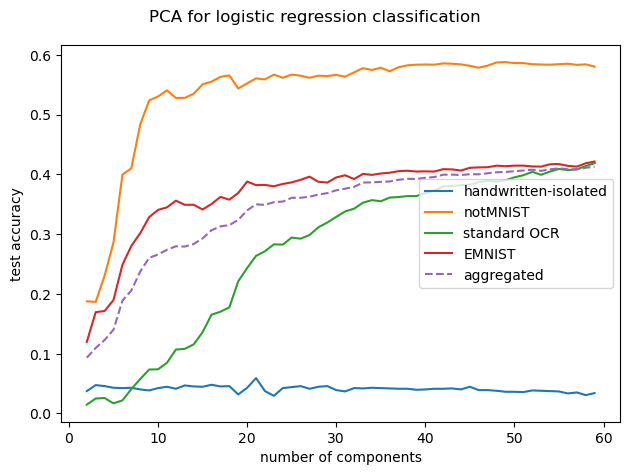

In [287]:
plot_scores(logreg_pca_results, range(2, 60), title="PCA for logistic regression classification")

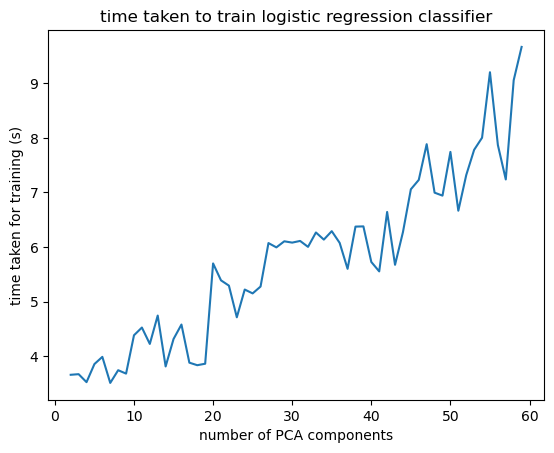

In [288]:
plt.plot(range(2, 60), logreg_pca_results["traintimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for training (s)")
plt.title("time taken to train logistic regression classifier")
plt.show()

### KNN classifier

In [289]:
knn_pca_results = test_trf_models(create_knn, pcatrf_funcs, 2, 59)

n_components: 2
KNN training took: 0.42061614990234375 sec.

Model testing took: 0.21036171913146973 sec.

handwritten-isolated score: 0.2734375
notMNIST score: 0.1778846153846154
standard OCR score: 0.048011296775711934
EMNIST score: 0.16940789473684212
Aggregate score: 0.14619883040935672
------
n_components: 3
KNN training took: 0.22087311744689941 sec.

Model testing took: 0.22321105003356934 sec.

handwritten-isolated score: 0.31919642857142855
notMNIST score: 0.2951388888888889
standard OCR score: 0.08519651682748883
EMNIST score: 0.22631578947368422
Aggregate score: 0.21263157894736842
------
n_components: 4
KNN training took: 0.20313096046447754 sec.

Model testing took: 0.23586416244506836 sec.

handwritten-isolated score: 0.3247767857142857
notMNIST score: 0.38648504273504275
standard OCR score: 0.17580607201694518
EMNIST score: 0.2792763157894737
Aggregate score: 0.2826510721247563
------
n_components: 5
KNN training took: 0.19126510620117188 sec.

Model testing took: 0.2734

In [290]:
np.max(knn_pca_results["aggscores"])

0.8038986354775829

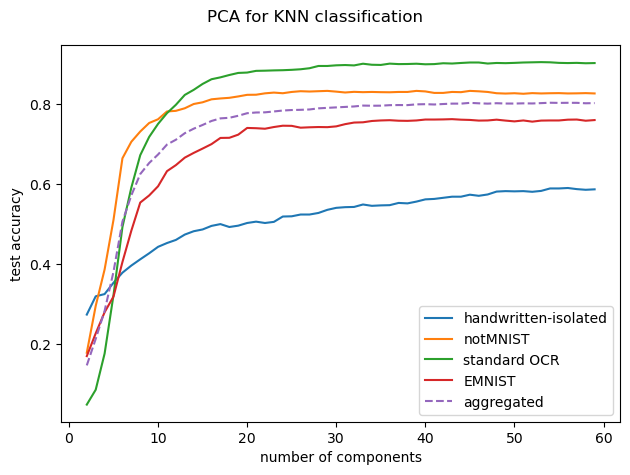

In [291]:
plot_scores(knn_pca_results, range(2, 60), title="PCA for KNN classification")

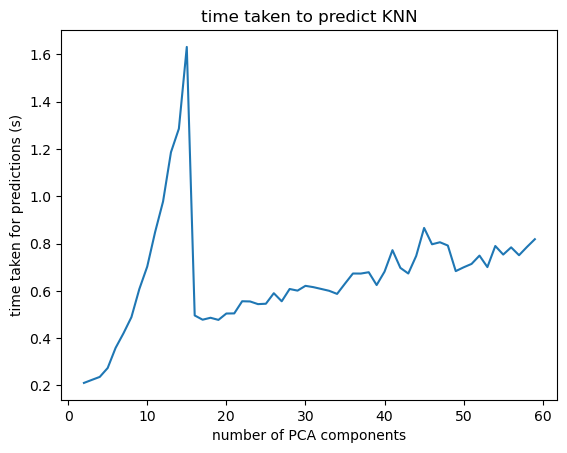

In [312]:
plt.plot(range(2, 60), knn_pca_results["predicttimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for predictions (s)")
plt.title("time taken to predict KNN")
plt.show()

## Tests with LDA

In [293]:
def create_lda(X, y, n_components):
    ts = utils.tic()
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    lda.fit(X, y)
    utils.toc(ts, "Creating LDA components")
    return lda
allldas = [create_lda(cons_train_data, cons_train_labels, i) for i in range(1, 35)]
ldatrf_funcs = [lda.transform for lda in allldas]

Creating LDA components took: 7.078799247741699 sec.

Creating LDA components took: 5.725399971008301 sec.

Creating LDA components took: 6.263491153717041 sec.

Creating LDA components took: 6.083444833755493 sec.

Creating LDA components took: 5.590220212936401 sec.

Creating LDA components took: 5.827617883682251 sec.

Creating LDA components took: 6.365244150161743 sec.

Creating LDA components took: 5.641034126281738 sec.

Creating LDA components took: 5.458297967910767 sec.

Creating LDA components took: 6.113397836685181 sec.

Creating LDA components took: 9.149030208587646 sec.

Creating LDA components took: 6.401356220245361 sec.

Creating LDA components took: 11.435538291931152 sec.

Creating LDA components took: 6.181217908859253 sec.

Creating LDA components took: 7.108111143112183 sec.

Creating LDA components took: 7.03410005569458 sec.

Creating LDA components took: 9.552931785583496 sec.

Creating LDA components took: 8.320994138717651 sec.

Creating LDA components took

In [294]:
ldatrf_funcs = [lda.transform for lda in allldas]

### Logistic regression linear classifier

In [295]:
logreg_lda_results = test_trf_models(create_logreg, ldatrf_funcs, 1, 34)

n_components: 1
Logistic Regression training took: 0.7483880519866943 sec.

Model testing took: 0.06745004653930664 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.13835470085470086
standard OCR score: 0.04730524829371617
EMNIST score: 0.08157894736842106
Aggregate score: 0.08132553606237816
------
n_components: 2
Logistic Regression training took: 0.8579659461975098 sec.

Model testing took: 0.039643049240112305 sec.

handwritten-isolated score: 0.029017857142857144
notMNIST score: 0.21768162393162394
standard OCR score: 0.04518710284772888
EMNIST score: 0.2013157894736842
Aggregate score: 0.1302923976608187
------
n_components: 3
Logistic Regression training took: 1.073214054107666 sec.

Model testing took: 0.057763099670410156 sec.

handwritten-isolated score: 0.029017857142857144
notMNIST score: 0.2825854700854701
standard OCR score: 0.07342904212755942
EMNIST score: 0.24111842105263157
Aggregate score: 0.16803118908382067
------
n_components: 4
Logistic Reg

In [296]:
np.max(logreg_lda_results["aggscores"])

0.4176998050682261

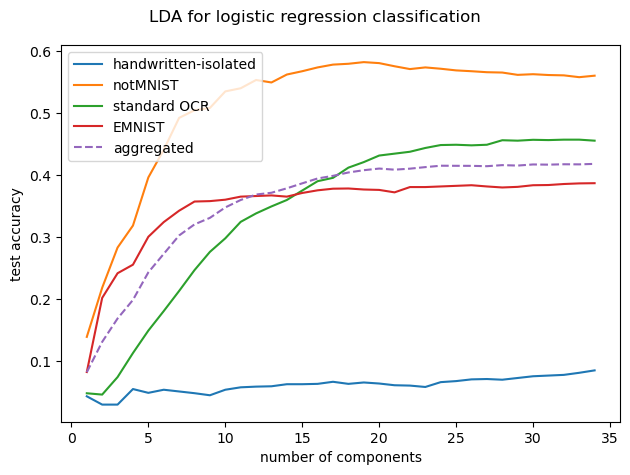

In [297]:
plot_scores(logreg_lda_results, range(1, 35), title="LDA for logistic regression classification")

### KNN classifier

In [298]:
knn_lda_results = test_trf_models(create_knn, ldatrf_funcs, 1, 34)

n_components: 1
KNN training took: 0.23538589477539062 sec.

Model testing took: 0.23496794700622559 sec.

handwritten-isolated score: 0.20145089285714285
notMNIST score: 0.10016025641025642
standard OCR score: 0.04542245234172747
EMNIST score: 0.09539473684210527
Aggregate score: 0.09504873294346979
------
n_components: 2
KNN training took: 0.16946792602539062 sec.

Model testing took: 0.20495080947875977 sec.

handwritten-isolated score: 0.23158482142857142
notMNIST score: 0.18162393162393162
standard OCR score: 0.06942810072958343
EMNIST score: 0.16907894736842105
Aggregate score: 0.14846003898635476
------
n_components: 3
KNN training took: 0.16876983642578125 sec.

Model testing took: 0.3192260265350342 sec.

handwritten-isolated score: 0.32421875
notMNIST score: 0.28338675213675213
standard OCR score: 0.10284772887738292
EMNIST score: 0.20164473684210527
Aggregate score: 0.20990253411306042
------
n_components: 4
KNN training took: 0.16770267486572266 sec.

Model testing took: 0.

In [299]:
np.max(knn_lda_results["aggscores"])

0.6708771929824562

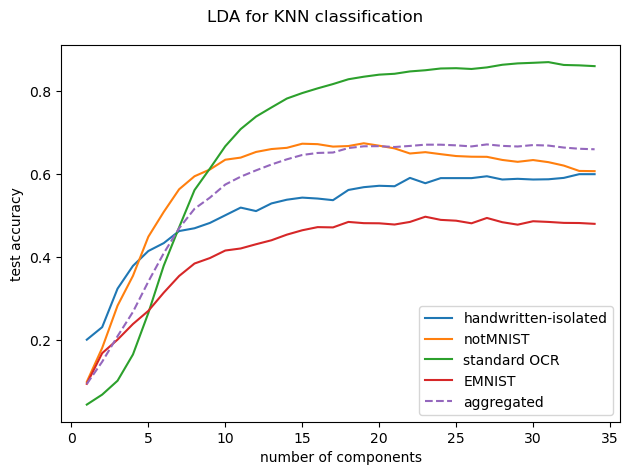

In [300]:
plot_scores(knn_lda_results, range(1, 35), title="LDA for KNN classification")

## Tests with random Gaussian projection

In [301]:
allgrps = [GaussianRandomProjection(n_components=i, random_state=1).fit(cons_train_data) for i in range(2, 60)]
rgptrf_funcs = [grp.transform for grp in allgrps]

### Logistic regression

In [302]:
logreg_rgp_results = test_trf_models(create_logreg, rgptrf_funcs, 2, 59)

n_components: 2


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.3396120071411133 sec.

Model testing took: 0.0171048641204834 sec.

handwritten-isolated score: 0.027901785714285716
notMNIST score: 0.13808760683760685
standard OCR score: 0.01670981407389974
EMNIST score: 0.05756578947368421
Aggregate score: 0.06339181286549708
------
n_components: 3


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.2592198848724365 sec.

Model testing took: 0.03170895576477051 sec.

handwritten-isolated score: 0.03404017857142857
notMNIST score: 0.13995726495726496
standard OCR score: 0.014827018121911038
EMNIST score: 0.08980263157894737
Aggregate score: 0.07181286549707602
------
n_components: 4


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.424046039581299 sec.

Model testing took: 0.019509077072143555 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.2045940170940171
standard OCR score: 0.01459166862791245
EMNIST score: 0.12861842105263158
Aggregate score: 0.1002729044834308
------
n_components: 5


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.5510919094085693 sec.

Model testing took: 0.02687382698059082 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.24145299145299146
standard OCR score: 0.016474464579901153
EMNIST score: 0.1305921052631579
Aggregate score: 0.11368421052631579
------
n_components: 6


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.357846975326538 sec.

Model testing took: 0.040891170501708984 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.22756410256410256
standard OCR score: 0.024005648387855967
EMNIST score: 0.13486842105263158
Aggregate score: 0.1122027290448343
------
n_components: 7


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.3108131885528564 sec.

Model testing took: 0.021893024444580078 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.23317307692307693
standard OCR score: 0.031066133207813602
EMNIST score: 0.14769736842105263
Aggregate score: 0.11937621832358675
------
n_components: 8


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.4999210834503174 sec.

Model testing took: 0.025614023208618164 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.2419871794871795
standard OCR score: 0.032948929159802305
EMNIST score: 0.15756578947368421
Aggregate score: 0.12475633528265107
------
n_components: 9


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.152340888977051 sec.

Model testing took: 0.030565977096557617 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.27323717948717946
standard OCR score: 0.03436102612379383
EMNIST score: 0.16578947368421051
Aggregate score: 0.13653021442495128
------
n_components: 10


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.4507670402526855 sec.

Model testing took: 0.022507190704345703 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.30822649572649574
standard OCR score: 0.03341962814779948
EMNIST score: 0.1763157894736842
Aggregate score: 0.14962962962962964
------
n_components: 11


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.5706968307495117 sec.

Model testing took: 0.04988694190979004 sec.

handwritten-isolated score: 0.056919642857142856
notMNIST score: 0.3173076923076923
standard OCR score: 0.0369498705577783
EMNIST score: 0.1944078947368421
Aggregate score: 0.1589083820662768
------
n_components: 12


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.701948881149292 sec.

Model testing took: 0.026475191116333008 sec.

handwritten-isolated score: 0.06305803571428571
notMNIST score: 0.3301282051282051
standard OCR score: 0.042598258413744414
EMNIST score: 0.19736842105263158
Aggregate score: 0.16608187134502925
------
n_components: 13


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.640212059020996 sec.

Model testing took: 0.03666996955871582 sec.

handwritten-isolated score: 0.05915178571428571
notMNIST score: 0.3418803418803419
standard OCR score: 0.042362908919745826
EMNIST score: 0.20526315789473684
Aggregate score: 0.17076023391812867
------
n_components: 14


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.576205015182495 sec.

Model testing took: 0.04974699020385742 sec.

handwritten-isolated score: 0.05803571428571429
notMNIST score: 0.35336538461538464
standard OCR score: 0.05365968463167804
EMNIST score: 0.2026315789473684
Aggregate score: 0.17707602339181286
------
n_components: 15


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.7141339778900146 sec.

Model testing took: 0.051207780838012695 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.35870726495726496
standard OCR score: 0.05930807248764415
EMNIST score: 0.20296052631578948
Aggregate score: 0.17996101364522418
------
n_components: 16


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.878371238708496 sec.

Model testing took: 0.027419090270996094 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.3720619658119658
standard OCR score: 0.06260296540362438
EMNIST score: 0.2075657894736842
Aggregate score: 0.1858869395711501
------
n_components: 17


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.660276174545288 sec.

Model testing took: 0.037000179290771484 sec.

handwritten-isolated score: 0.05078125
notMNIST score: 0.37286324786324787
standard OCR score: 0.07413509060955518
EMNIST score: 0.22072368421052632
Aggregate score: 0.19282651072124757
------
n_components: 18


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.539095163345337 sec.

Model testing took: 0.037503957748413086 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.39663461538461536
standard OCR score: 0.07837138150152977
EMNIST score: 0.22894736842105262
Aggregate score: 0.20257309941520468
------
n_components: 19


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.600369930267334 sec.

Model testing took: 0.03593015670776367 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.41773504273504275
standard OCR score: 0.0837844198634973
EMNIST score: 0.22828947368421051
Aggregate score: 0.21060428849902535
------
n_components: 20


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.463447093963623 sec.

Model testing took: 0.04059600830078125 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.43349358974358976
standard OCR score: 0.09861143798540833
EMNIST score: 0.24605263157894736
Aggregate score: 0.2242495126705653
------
n_components: 21


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.6131391525268555 sec.

Model testing took: 0.031161069869995117 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.44604700854700857
standard OCR score: 0.09861143798540833
EMNIST score: 0.24407894736842106
Aggregate score: 0.22752436647173488
------
n_components: 22


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.611991882324219 sec.

Model testing took: 0.025671958923339844 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.45058760683760685
standard OCR score: 0.11108496116733349
EMNIST score: 0.2542763157894737
Aggregate score: 0.23578947368421052
------
n_components: 23


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.60490083694458 sec.

Model testing took: 0.027897119522094727 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.4543269230769231
standard OCR score: 0.12026359143327842
EMNIST score: 0.25493421052631576
Aggregate score: 0.2403898635477583
------
n_components: 24


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.611923933029175 sec.

Model testing took: 0.0367588996887207 sec.

handwritten-isolated score: 0.049107142857142856
notMNIST score: 0.4567307692307692
standard OCR score: 0.1263826782772417
EMNIST score: 0.25921052631578945
Aggregate score: 0.24350877192982456
------
n_components: 25


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.719002962112427 sec.

Model testing took: 0.03112506866455078 sec.

handwritten-isolated score: 0.05022321428571429
notMNIST score: 0.45699786324786323
standard OCR score: 0.13108966815721346
EMNIST score: 0.25921052631578945
Aggregate score: 0.24530214424951266
------
n_components: 26


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.966938018798828 sec.

Model testing took: 0.04055595397949219 sec.

handwritten-isolated score: 0.05078125
notMNIST score: 0.45860042735042733
standard OCR score: 0.13461991056719227
EMNIST score: 0.2680921052631579
Aggregate score: 0.24912280701754386
------
n_components: 27


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.660482883453369 sec.

Model testing took: 0.039999961853027344 sec.

handwritten-isolated score: 0.05078125
notMNIST score: 0.4706196581196581
standard OCR score: 0.1416803953871499
EMNIST score: 0.27171052631578946
Aggregate score: 0.25582846003898635
------
n_components: 28


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.154078960418701 sec.

Model testing took: 0.04811739921569824 sec.

handwritten-isolated score: 0.053013392857142856
notMNIST score: 0.4740918803418803
standard OCR score: 0.1435631913391386
EMNIST score: 0.2743421052631579
Aggregate score: 0.258401559454191
------
n_components: 29


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.731131076812744 sec.

Model testing took: 0.05166196823120117 sec.

handwritten-isolated score: 0.056361607142857144
notMNIST score: 0.47489316239316237
standard OCR score: 0.14615203577312308
EMNIST score: 0.2730263157894737
Aggregate score: 0.2596491228070175
------
n_components: 30


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.691986083984375 sec.

Model testing took: 0.03341412544250488 sec.

handwritten-isolated score: 0.05189732142857143
notMNIST score: 0.46821581196581197
standard OCR score: 0.1534478700870793
EMNIST score: 0.2792763157894737
Aggregate score: 0.2609746588693957
------
n_components: 31


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.474925994873047 sec.

Model testing took: 0.0659799575805664 sec.

handwritten-isolated score: 0.053013392857142856
notMNIST score: 0.469017094017094
standard OCR score: 0.16192045187102846
EMNIST score: 0.2845394736842105
Aggregate score: 0.26541910331384017
------
n_components: 32


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.002288818359375 sec.

Model testing took: 0.05230116844177246 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.46928418803418803
standard OCR score: 0.16074370440103553
EMNIST score: 0.2858552631578947
Aggregate score: 0.2649512670565302
------
n_components: 33


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.7097249031066895 sec.

Model testing took: 0.057412147521972656 sec.

handwritten-isolated score: 0.05524553571428571
notMNIST score: 0.4700854700854701
standard OCR score: 0.17274652859496353
EMNIST score: 0.2930921052631579
Aggregate score: 0.2716569200779727
------
n_components: 34


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.419523000717163 sec.

Model testing took: 0.04177093505859375 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.46981837606837606
standard OCR score: 0.17580607201694518
EMNIST score: 0.29736842105263156
Aggregate score: 0.27321637426900586
------
n_components: 35


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.275170087814331 sec.

Model testing took: 0.04529309272766113 sec.

handwritten-isolated score: 0.05412946428571429
notMNIST score: 0.47435897435897434
standard OCR score: 0.17957166392092258
EMNIST score: 0.3046052631578947
Aggregate score: 0.27773879142300195
------
n_components: 36


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.631582975387573 sec.

Model testing took: 0.04578208923339844 sec.

handwritten-isolated score: 0.053013392857142856
notMNIST score: 0.4740918803418803
standard OCR score: 0.1849847022828901
EMNIST score: 0.30855263157894736
Aggregate score: 0.28023391812865495
------
n_components: 37


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.6493449211120605 sec.

Model testing took: 0.04077410697937012 sec.

handwritten-isolated score: 0.05412946428571429
notMNIST score: 0.47596153846153844
standard OCR score: 0.18616144975288304
EMNIST score: 0.3078947368421053
Aggregate score: 0.28116959064327485
------
n_components: 38


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.927716016769409 sec.

Model testing took: 0.050563812255859375 sec.

handwritten-isolated score: 0.05412946428571429
notMNIST score: 0.4754273504273504
standard OCR score: 0.19016239115085903
EMNIST score: 0.30986842105263157
Aggregate score: 0.2828070175438597
------
n_components: 39


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.061823129653931 sec.

Model testing took: 0.04702591896057129 sec.

handwritten-isolated score: 0.05524553571428571
notMNIST score: 0.47302350427350426
standard OCR score: 0.19534008001882797
EMNIST score: 0.30986842105263157
Aggregate score: 0.2839766081871345
------
n_components: 40


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.939636945724487 sec.

Model testing took: 0.04644608497619629 sec.

handwritten-isolated score: 0.05078125
notMNIST score: 0.4735576923076923
standard OCR score: 0.19910567192280537
EMNIST score: 0.3167763157894737
Aggregate score: 0.28639376218323587
------
n_components: 41


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.680129051208496 sec.

Model testing took: 0.07049989700317383 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.47489316239316237
standard OCR score: 0.20875500117674747
EMNIST score: 0.31546052631578947
Aggregate score: 0.28912280701754384
------
n_components: 42


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.4852001667022705 sec.

Model testing took: 0.11042594909667969 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.4722222222222222
standard OCR score: 0.20946104965874324
EMNIST score: 0.3194078947368421
Aggregate score: 0.28990253411306044
------
n_components: 43


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.3308069705963135 sec.

Model testing took: 0.04949498176574707 sec.

handwritten-isolated score: 0.05524553571428571
notMNIST score: 0.4807692307692308
standard OCR score: 0.21110849611673335
EMNIST score: 0.31743421052631576
Aggregate score: 0.29325536062378166
------
n_components: 44


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.330359935760498 sec.

Model testing took: 0.03723883628845215 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.47836538461538464
standard OCR score: 0.21628618498470228
EMNIST score: 0.3203947368421053
Aggregate score: 0.29473684210526313
------
n_components: 45


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.978806018829346 sec.

Model testing took: 0.05252408981323242 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.4740918803418803
standard OCR score: 0.22122852435867263
EMNIST score: 0.3213815789473684
Aggregate score: 0.2952046783625731
------
n_components: 46


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.9511659145355225 sec.

Model testing took: 0.04298806190490723 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.4909188034188034
standard OCR score: 0.21911037891268534
EMNIST score: 0.32105263157894737
Aggregate score: 0.29949317738791426
------
n_components: 47


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.775940179824829 sec.

Model testing took: 0.06799912452697754 sec.

handwritten-isolated score: 0.05524553571428571
notMNIST score: 0.4855769230769231
standard OCR score: 0.22405271828665568
EMNIST score: 0.3269736842105263
Aggregate score: 0.3012085769980507
------
n_components: 48


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.472879886627197 sec.

Model testing took: 0.05425381660461426 sec.

handwritten-isolated score: 0.0546875
notMNIST score: 0.48691239316239315
standard OCR score: 0.22499411626265003
EMNIST score: 0.3269736842105263
Aggregate score: 0.30183235867446395
------
n_components: 49


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.923567056655884 sec.

Model testing took: 0.09111499786376953 sec.

handwritten-isolated score: 0.05580357142857143
notMNIST score: 0.48824786324786323
standard OCR score: 0.2332313485526006
EMNIST score: 0.32861842105263156
Aggregate score: 0.3054970760233918
------
n_components: 50


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.017869234085083 sec.

Model testing took: 0.09419798851013184 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.48664529914529914
standard OCR score: 0.23817368792657095
EMNIST score: 0.33092105263157895
Aggregate score: 0.3069005847953216
------
n_components: 51


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.937790870666504 sec.

Model testing took: 0.09687113761901855 sec.

handwritten-isolated score: 0.049107142857142856
notMNIST score: 0.49011752136752135
standard OCR score: 0.24546952224052718
EMNIST score: 0.33421052631578946
Aggregate score: 0.31048732943469787
------
n_components: 52


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.7055699825286865 sec.

Model testing took: 0.05077004432678223 sec.

handwritten-isolated score: 0.05022321428571429
notMNIST score: 0.49145299145299143
standard OCR score: 0.2504118616144975
EMNIST score: 0.3361842105263158
Aggregate score: 0.3131384015594542
------
n_components: 53


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.67460298538208 sec.

Model testing took: 0.06519079208374023 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.4890491452991453
standard OCR score: 0.253000706048482
EMNIST score: 0.3371710526315789
Aggregate score: 0.3136842105263158
------
n_components: 54


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.520593881607056 sec.

Model testing took: 0.042088985443115234 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.49572649572649574
standard OCR score: 0.25582489997646507
EMNIST score: 0.3401315789473684
Aggregate score: 0.3168810916179337
------
n_components: 55


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.041200876235962 sec.

Model testing took: 0.05400490760803223 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.4949252136752137
standard OCR score: 0.2588844433984467
EMNIST score: 0.33980263157894736
Aggregate score: 0.3171150097465887
------
n_components: 56


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.601222991943359 sec.

Model testing took: 0.03617715835571289 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.5024038461538461
standard OCR score: 0.2591197928924453
EMNIST score: 0.3430921052631579
Aggregate score: 0.3201559454191033
------
n_components: 57


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.636379241943359 sec.

Model testing took: 0.04970383644104004 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.49732905982905984
standard OCR score: 0.25817839491645095
EMNIST score: 0.34375
Aggregate score: 0.3178947368421053
------
n_components: 58


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.499812841415405 sec.

Model testing took: 0.06538009643554688 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.49759615384615385
standard OCR score: 0.26123793833843256
EMNIST score: 0.3450657894736842
Aggregate score: 0.32
------
n_components: 59
Logistic Regression training took: 5.29203987121582 sec.

Model testing took: 0.0463559627532959 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.49919871794871795
standard OCR score: 0.26006119086843965
EMNIST score: 0.3404605263157895
Aggregate score: 0.31883040935672513
------


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [303]:
np.max(logreg_rgp_results["aggscores"])

0.3201559454191033

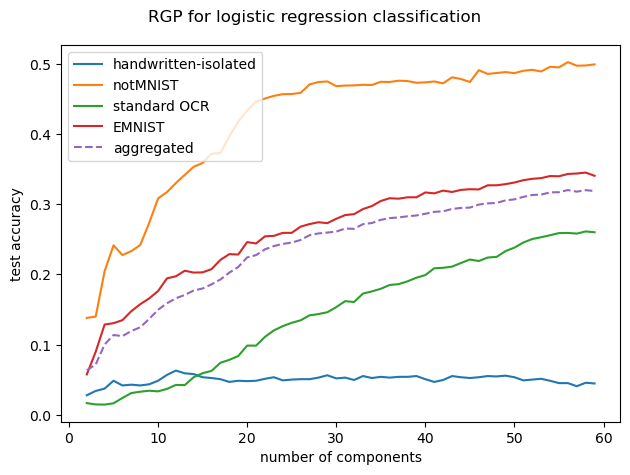

In [304]:
plot_scores(logreg_rgp_results, range(2, 60), title="RGP for logistic regression classification")

### KNN

In [305]:
knn_rgp_results = test_trf_models(create_knn, rgptrf_funcs, 2, 59)

n_components: 2


KNN training took: 0.1815030574798584 sec.

Model testing took: 0.19801783561706543 sec.

handwritten-isolated score: 0.23604910714285715
notMNIST score: 0.06677350427350427
standard OCR score: 0.03318427865380089
EMNIST score: 0.07664473684210527
Aggregate score: 0.0816374269005848
------
n_components: 3
KNN training took: 0.1156010627746582 sec.

Model testing took: 0.21065187454223633 sec.

handwritten-isolated score: 0.27901785714285715
notMNIST score: 0.11004273504273504
standard OCR score: 0.06072016945163568
EMNIST score: 0.10625
Aggregate score: 0.11641325536062379
------
n_components: 4
KNN training took: 0.10764098167419434 sec.

Model testing took: 0.23465180397033691 sec.

handwritten-isolated score: 0.35323660714285715
notMNIST score: 0.18803418803418803
standard OCR score: 0.10261237938338433
EMNIST score: 0.1375
Aggregate score: 0.17083820662768032
------
n_components: 5
KNN training took: 0.1099851131439209 sec.

Model testing took: 0.3023550510406494 sec.

handwritten-

In [306]:
np.max(knn_rgp_results["aggscores"])

0.7421442495126706

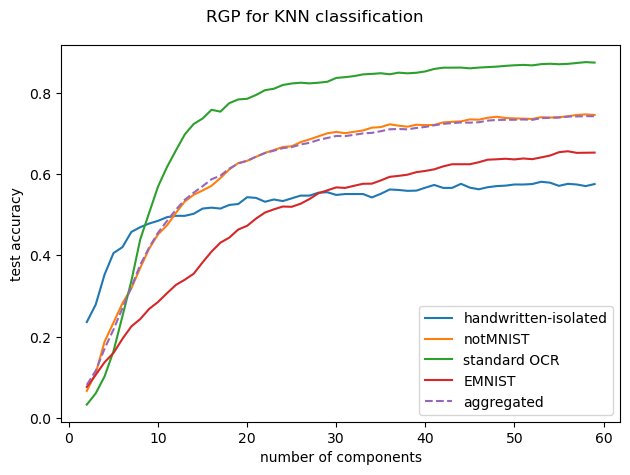

In [307]:
plot_scores(knn_rgp_results, range(2, 60), title="RGP for KNN classification")

## MPCA

Code taken from https://github.com/tensorly/Proceedings_IEEE_companion_notebooks/blob/master/MPCA.ipynb

In [308]:
def compute_modek_total_scatter(X, mode, factors):
    scatter = 0
    
    for m in range(len(X)):
        proj_but_k = tl.unfold(tl.tenalg.multi_mode_dot(X[m], factors, transpose=True, skip=mode), mode)
        scatter += tl.dot(proj_but_k, proj_but_k.T)
        
    return scatter

def MPCA(X, rank, niters=1, size=28):
    X = tl.tensor(X.reshape(-1, size, size).astype(float))
    Xmean = tl.mean(X, axis=0)
    X = X - Xmean
    factors = [tl.ones((dim, rank)) for dim in X.shape[1:]]

    num_modes = len(X.shape) - 1
    niters = niters

    for _ in range(niters):
        for k in range(num_modes):
            scatter = compute_modek_total_scatter(X, k, factors)
            U, _, _ = tl.tenalg.svd_interface(scatter, n_eigenvecs=rank)
            factors[k] = U

    def _MCPA_func(X):
        X = tl.tensor(X.reshape(-1, size, size).astype(float))
        X = X - Xmean
        res = tl.tenalg.multi_mode_dot(X, factors, modes=[1, 2], transpose=True)
        return res
    return _MCPA_func

# need this wrapper because defining lambdas in for loops just doesn't
# work like intended
def _get_flatten_mpca_func(mpca, rank):
    return lambda x: mpca(x).reshape(-1, rank ** 2)

allranks = list(range(4, 26))
allmpcas = [MPCA(cons_train_data, i, niters=1, size=28) for i in allranks]
mpcatrf_funcs = [_get_flatten_mpca_func(mpca, allranks[i]) for i, mpca in enumerate(allmpcas)]

### KNN

In [309]:
knn_mpca_results = test_trf_models(create_knn, mpcatrf_funcs, 4, 25)

n_components: 4
KNN training took: 0.49823904037475586 sec.

Model testing took: 0.5043871402740479 sec.

handwritten-isolated score: 0.47544642857142855
notMNIST score: 0.8004807692307693
standard OCR score: 0.8562014591668627
EMNIST score: 0.6661184210526315
Aggregate score: 0.7416764132553606
------
n_components: 5
KNN training took: 0.47594523429870605 sec.

Model testing took: 0.5813019275665283 sec.

handwritten-isolated score: 0.5200892857142857
notMNIST score: 0.8167735042735043
standard OCR score: 0.8912685337726524
EMNIST score: 0.6996710526315789
Aggregate score: 0.7722417153996102
------
n_components: 6
KNN training took: 0.47665882110595703 sec.

Model testing took: 0.6457507610321045 sec.

handwritten-isolated score: 0.5334821428571429
notMNIST score: 0.8218482905982906
standard OCR score: 0.9042127559425748
EMNIST score: 0.7460526315789474
Aggregate score: 0.7908771929824562
------
n_components: 7
KNN training took: 0.47225069999694824 sec.

Model testing took: 0.7404131

In [310]:
np.max(knn_mpca_results["aggscores"])

0.8037426900584795

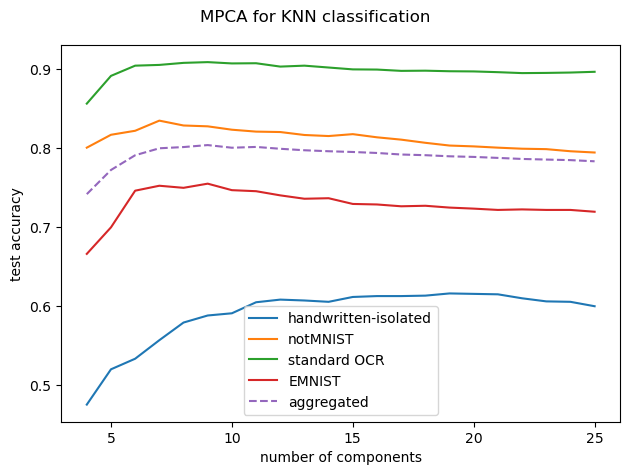

In [311]:
plot_scores(knn_mpca_results, range(4, 26), title="MPCA for KNN classification")

testing stuff here

In [102]:
X = tl.tensor(notmnist_test_data.reshape(-1, 28, 28).astype(float))
Xmean = tl.mean(X, axis=0)
Xcent = X - Xmean

In [230]:
mcpa = MPCA(X, 10)

In [231]:
asdf = mcpa(X)

(3744, 10, 10)


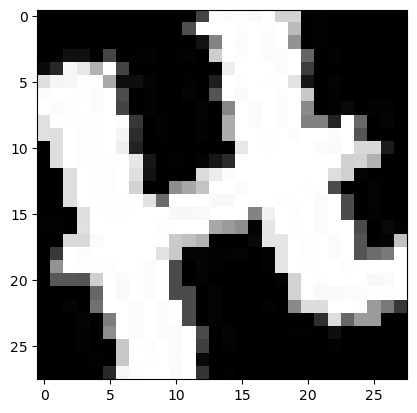

In [232]:
plt.imshow(X[0], cmap="gray")

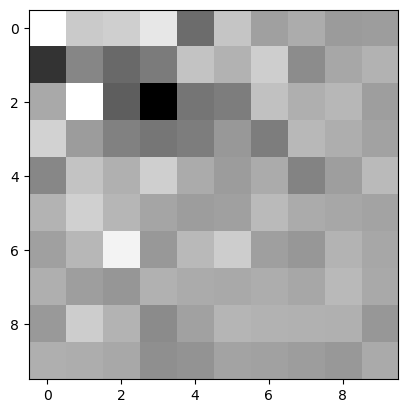

In [233]:
plt.imshow(asdf[0], cmap="gray")

## CNN tests

TODO these need to be done a datahub or someones laptop will explode

In [6]:
# remake these datasets with a new transform to keep them as a tensor

# this dataset is already random rotated
handiso_ds_train = utils.CharDataset("data/handwritten-isolated-english/train", transform=utils.T_tensor, label_transform=utils.class_to_idx)
handiso_ds_test = utils.CharDataset("data/handwritten-isolated-english/test", transform=utils.T_tensor, label_transform=utils.class_to_idx)

notmnist_ds = utils.CharDataset("data/notMNIST_small", transform=utils.T_randrottensor, label_transform=utils.class_to_idx)
notmnist_ds_train, notmnist_ds_test = random_split(notmnist_ds, [0.8, 0.2])

stdocr_ds_train_orig = (
    utils.CharDataset("data/standard_ocr_dataset/data/training_data", transform=utils.T_randrottensor, label_transform=utils.class_to_idx) +
    utils.CharDataset("data/standard_ocr_dataset/data2/training_data", transform=utils.T_randrottensor, label_transform=utils.class_to_idx)
)
stdocr_ds_test = (
    utils.CharDataset("data/standard_ocr_dataset/data/testing_data", transform=utils.T_randrottensor, label_transform=utils.class_to_idx) +
    utils.CharDataset("data/standard_ocr_dataset/data2/testing_data", transform=utils.T_randrottensor, label_transform=utils.class_to_idx)
)

mnist_ds_train_letters = EMNIST(Path(os.getcwd(), "data"), "letters", download=True, train=True, transform=utils.T_randrottensor, target_transform=utils.emnistletter_idx_to_allidx)
mnist_ds_train_digits = EMNIST(Path(os.getcwd(), "data"), "digits", download=True, train=True, transform=utils.T_randrottensor)
mnist_ds_train_orig = mnist_ds_train_letters + mnist_ds_train_digits
mnist_ds_test_letters = EMNIST(Path(os.getcwd(), "data"), "letters", download=True, train=False, transform=utils.T_randrottensor, target_transform=utils.emnistletter_idx_to_allidx)
mnist_ds_test_digits = EMNIST(Path(os.getcwd(), "data"), "digits", download=True, train=False, transform=utils.T_randrottensor)
mnist_ds_test_orig = mnist_ds_test_letters + mnist_ds_test_digits

stdocr_ds_train, _ = random_split(stdocr_ds_train_orig, [0.5, 0.5])
mnist_ds_train, _ = random_split(mnist_ds_train_orig, [0.05, 0.95])
mnist_ds_test, _ = random_split(mnist_ds_test_orig, [0.05, 0.95])

consolidated_ds_train = handiso_ds_train + notmnist_ds_train + stdocr_ds_train + mnist_ds_train
consolidated_ds_test = handiso_ds_test + notmnist_ds_test + stdocr_ds_test + mnist_ds_test

In [ ]:
trainloader = torch.utils.data.DataLoader(consolidated_ds_train, num_workers=31, batch_size=32)
testloader = torch.utils.data.DataLoader(consolidated_ds_test, num_workers=31, batch_size=32)

In [ ]:
genCNN = utils.GenericCharCNN()
trainer = L.Trainer(max_epochs=30)
trainer.fit(model=genCNN, train_dataloaders=trainloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 156   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 30.8 K
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 3.1 K 
------------------------------------
46.6 K    Trainable params
0         Non-trainable params
46.6 K    Total params
0.187     Total estimated model params size (MB)


Epoch 3:   0%|          | 0/2095 [00:00<?, ?it/s, v_num=1]           

Exception ignored in: <function _releaseLock at 0x7f5a1ff2cb80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [ ]:
trainer.test(genCNN, dataloaders=testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 401/401 [00:21<00:00, 18.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.05871345102787018
        test_loss            4.275759696960449
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 4.275759696960449, 'test_acc': 0.05871345102787018}]